In [4]:
%matplotlib inline

import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch                    
import torchvision
import fasttext

In [5]:
data = pd.read_csv('/kaggle/input/flickr8k/captions.txt')

In [6]:
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
data.shape

(40455, 2)

In [8]:
data['click'] = pd.Series(np.random.randint(0, 2, (1, data.shape[0])).flatten())

In [9]:
data.head()

,image,caption,click
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,1
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0


In [12]:
from PIL import Image


images = [
    Image.open(
        "/kaggle/input/flickr8k/Images" + "/" + data.loc[i, "image"]
    ).convert("RGB")
    for i in range(0, 50, 10)
]

for image in images:
    print(image.size)

(375, 500)
(500, 400)
(500, 461)
(500, 333)
(500, 375)


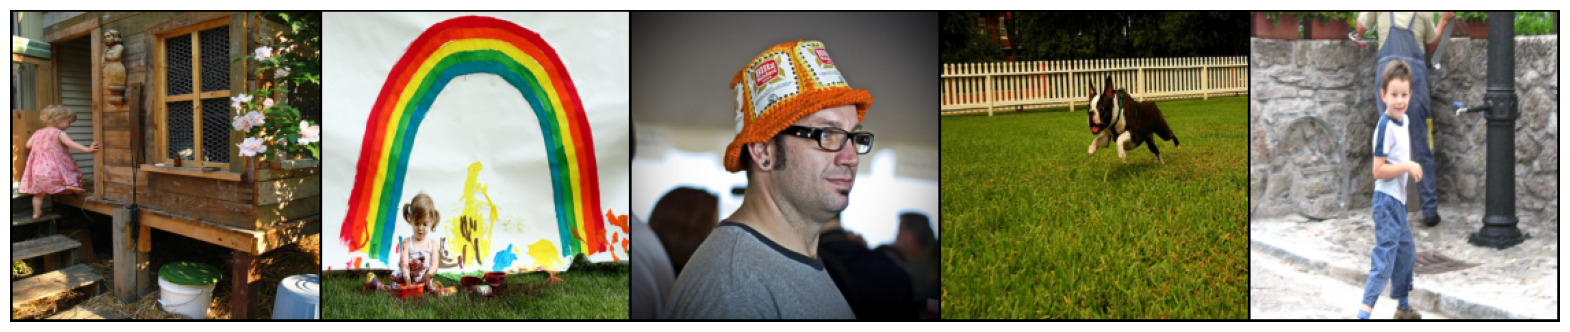

In [13]:
# define a callable image_transform with Compose
image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor()
    ]
)

# convert the images and prepare for visualization.
tensor_img = torch.stack(
    [image_transform(image) for image in images]
)
grid = torchvision.utils.make_grid(tensor_img)

# plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.axis('off')
_ = plt.imshow(grid.permute(1, 2, 0))

In [83]:
class HatefulMemesDataset(torch.utils.data.Dataset):
    """Uses jsonl data to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(
        self,
        data_path,
        img_dir,
        image_transform,
        text_transform,
        balance=False,
        dev_limit=None,
        random_state=0,
    ):
        print(data_path)
        self.samples_frame = pd.read_csv(
            data_path
        )
        self.dev_limit = dev_limit
        if balance:
            neg = self.samples_frame[
                self.samples_frame.label.eq(0)
            ]
            pos = self.samples_frame[
                self.samples_frame.label.eq(1)
            ]
            self.samples_frame = pd.concat(
                [
                    neg.sample(
                        pos.shape[0], 
                        random_state=random_state
                    ), 
                    pos
                ]
            )
        if self.dev_limit:
            if self.samples_frame.shape[0] > self.dev_limit:
                self.samples_frame = self.samples_frame.sample(
                    dev_limit, random_state=random_state
                )
        self.samples_frame = self.samples_frame.reset_index(
            drop=True
        )
        self.samples_frame.img = self.samples_frame.apply(
            lambda row: (img_dir + "/" + row['image']), axis=1
        )

        # https://github.com/drivendataorg/pandas-path
#         print(self.samples_frame.img)
#         if not self.samples_frame.img.path.exists().all():
#             raise FileNotFoundError
#         if not self.samples_frame.img.path.is_file().all():
#             raise TypeError
            
        self.image_transform = image_transform
        self.text_transform = text_transform

    def __len__(self):
        """This method is called when you do len(instance) 
        for an instance of this class.
        """
        return len(self.samples_frame)

    def __getitem__(self, idx):
        """This method is called when you do instance[key] 
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # img_id = self.samples_frame.loc[idx, "id"]

        image = Image.open(
            self.samples_frame.loc[idx, "image"]
        ).convert("RGB")
        image = self.image_transform(image)

        text = torch.Tensor(
            self.text_transform.get_sentence_vector(
                self.samples_frame.loc[idx, "caption"]
            )
        ).squeeze()

        if "label" in self.samples_frame.columns:
            label = torch.Tensor(
                [self.samples_frame.loc[idx, "click"]]
            ).long().squeeze()
            sample = {
                # "id": img_id, 
                "image": image, 
                "text": text, 
                "label": label
            }
        else:
            sample = {
                # "id": img_id, 
                "image": image, 
                "text": text
            }

        return sample

In [84]:
class LanguageAndVisionConcat(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        loss_fn,
        language_module,
        vision_module,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p,
        
    ):
        super(LanguageAndVisionConcat, self).__init__()
        self.language_module = language_module
        self.vision_module = vision_module
        self.fusion = torch.nn.Linear(
            in_features=(language_feature_dim + vision_feature_dim), 
            out_features=fusion_output_size
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)
        
    def forward(self, text, image, label=None):
        text_features = torch.nn.functional.relu(
            self.language_module(text)
        )
        image_features = torch.nn.functional.relu(
            self.vision_module(image)
        )
        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            )
        )
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        loss = (
            self.loss_fn(pred, label) 
            if label is not None else label
        )
        return (pred, loss)

In [105]:
import pytorch_lightning as pl


# for the purposes of this post, we'll filter
# much of the lovely logging info from our LightningModule
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.WARNING)


class HatefulMemesModel(pl.LightningModule):
    def __init__(self, hparams):
        for data_key in ["train_path", "dev_path", "img_dir",]:
            # ok, there's one for-loop but it doesn't count
            if data_key not in hparams.keys():
                raise KeyError(
                    f"{data_key} is a required hparam in this model"
                )
        
        super(HatefulMemesModel, self).__init__()
        for key in hparams.keys():
            self.hparams[key] = hparams[key]
        
        # assign some hparams that get used in multiple places
        self.embedding_dim = self.hparams.get("embedding_dim", 300)
        self.language_feature_dim = self.hparams.get(
            "language_feature_dim", 300
        )
        self.vision_feature_dim = self.hparams.get(
            # balance language and vision features by default
            "vision_feature_dim", self.language_feature_dim
        )
        self.output_path = Path(
            self.hparams.get("output_path", "model-outputs")
        )
        self.output_path.mkdir(exist_ok=True)
        
        # instantiate transforms, datasets
        self.text_transform = self._build_text_transform()
        self.image_transform = self._build_image_transform()
        self.train_dataset = self._build_dataset("train_path")
        # self.dev_dataset = self._build_dataset("dev_path")
        
        # set up model and training
        self.model = self._build_model()
        self.trainer_params = self._get_trainer_params()
    
    ## Required LightningModule Methods (when validating) ##
    
    def forward(self, text, image, label=None):
        return self.model(text, image, label)

    def training_step(self, batch, batch_nb):
        preds, loss = self.forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )
        
        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        preds, loss = self.eval().forward(
            text=batch["text"], 
            image=batch["image"], 
            label=batch["label"]
        )
        
        return {"batch_val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack(
            tuple(
                output["batch_val_loss"] 
                for output in outputs
            )
        ).mean()
        
        return {
            "val_loss": avg_loss,
            "progress_bar":{"avg_val_loss": avg_loss}
        }

    def configure_optimizers(self):
        optimizers = [
            torch.optim.AdamW(
                self.model.parameters(), 
                lr=self.hparams.get("lr", 0.001)
            )
        ]
        schedulers = [
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizers[0]
            )
        ]
        return optimizers, schedulers
    
#     @pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, 
            shuffle=True, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )

#     @pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.dev_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )
    
    ## Convenience Methods ##
    
    def fit(self):
        self._set_seed(self.hparams.get("random_state", 42))
#         self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer = pl.Trainer(
          callbacks=None,
          max_epochs=10,
          accelerator="auto",
        )
        self.trainer.fit(self)
        
    def _set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    def _build_text_transform(self):
        with tempfile.NamedTemporaryFile() as ft_training_data:
            ft_path = Path(ft_training_data.name)
            with ft_path.open("w") as ft:
                training_data = []
                for line in open(self.hparams.get("train_path")).read().splitlines()[1:]:
                    training_data.append(line.split(',')[1] + "/n")
                for line in training_data:
                    ft.write(line + "\n")
                language_transform = fasttext.train_unsupervised(
                    str(ft_path),
                    model=self.hparams.get("fasttext_model", "cbow"),
                    dim=self.embedding_dim
                )
        return language_transform
    
    def _build_image_transform(self):
        image_dim = self.hparams.get("image_dim", 224)
        image_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(
                    size=(image_dim, image_dim)
                ),        
                torchvision.transforms.ToTensor(),
                # all torchvision models expect the same
                # normalization mean and std
                # https://pytorch.org/docs/stable/torchvision/models.html
                torchvision.transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)
                ),
            ]
        )
        return image_transform

    def _build_dataset(self, dataset_key):
        return HatefulMemesDataset(
            data_path=self.hparams.get(dataset_key, dataset_key),
            img_dir=self.hparams.get("img_dir"),
            image_transform=self.image_transform,
            text_transform=self.text_transform,
            # limit training samples only
#             dev_limit=(
#                 self.hparams.get("dev_limit", None) 
#                 if "train" in str(dataset_key) else None
#             ),
#             balance=True if "train" in str(dataset_key) else False,
        )
    
    def _build_model(self):
        # we're going to pass the outputs of our text
        # transform through an additional trainable layer
        # rather than fine-tuning the transform
        language_module = torch.nn.Linear(
                in_features=self.embedding_dim,
                out_features=self.language_feature_dim
        )
        
        # easiest way to get features rather than
        # classification is to overwrite last layer
        # with an identity transformation, we'll reduce
        # dimension using a Linear layer, resnet is 2048 out
        vision_module = torchvision.models.resnet152(
            pretrained=True
        )
        vision_module.fc = torch.nn.Linear(
                in_features=2048,
                out_features=self.vision_feature_dim
        )

        return LanguageAndVisionConcat(
            num_classes=self.hparams.get("num_classes", 2),
            loss_fn=torch.nn.CrossEntropyLoss(),
            language_module=language_module,
            vision_module=vision_module,
            language_feature_dim=self.language_feature_dim,
            vision_feature_dim=self.vision_feature_dim,
            fusion_output_size=self.hparams.get(
                "fusion_output_size", 512
            ),
            dropout_p=self.hparams.get("dropout_p", 0.1),
        )
    
    def _get_trainer_params(self):
        print(self.output_path)
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor=self.hparams.get(
                "checkpoint_monitor", "avg_val_loss"
            ),
            mode=self.hparams.get(
                "checkpoint_monitor_mode", "min"
            ),
            verbose=self.hparams.get("verbose", True)
        )

        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=self.hparams.get(
                "early_stop_monitor", "avg_val_loss"
            ),
            min_delta=self.hparams.get(
                "early_stop_min_delta", 0.001
            ),
            patience=self.hparams.get(
                "early_stop_patience", 3
            ),
            verbose=self.hparams.get("verbose", True),
        )

        trainer_params = {
            "checkpoint_callback": checkpoint_callback,
            "early_stop_callback": early_stop_callback,
            "default_save_path": self.output_path,
            "accumulate_grad_batches": self.hparams.get(
                "accumulate_grad_batches", 1
            ),
            "gpus": self.hparams.get("n_gpu", 1),
            "max_epochs": self.hparams.get("max_epochs", 100),
            "gradient_clip_val": self.hparams.get(
                "gradient_clip_value", 1
            ),
        }
        return trainer_params
            
    @torch.no_grad()
    def make_submission_frame(self, test_path):
        test_dataset = self._build_dataset(test_path)
        submission_frame = pd.DataFrame(
            index=test_dataset.samples_frame.id,
            columns=["proba", "label"]
        )
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16))
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            preds, _ = self.model.eval().to("cpu")(
                batch["text"], batch["image"]
            )
            submission_frame.loc[batch["id"], "proba"] = preds[:, 1]
            submission_frame.loc[batch["id"], "label"] = preds.argmax(dim=1)
        submission_frame.proba = submission_frame.proba.astype(float)
        submission_frame.label = submission_frame.label.astype(int)
        return submission_frame

In [106]:
hparams = {
    
    # Required hparams
    "train_path": "/kaggle/input/flickr8k/captions.txt",
    "dev_path": "/kaggle/input/flickr8k/", # ???
    "img_dir": '/kaggle/input/flickr8k/Images',
    
    # Optional hparams
    "embedding_dim": 150,
    "language_feature_dim": 300,
    "vision_feature_dim": 300,
    "fusion_output_size": 256,
    "output_path": "/kaggle/working/",
    "dev_limit": None,
    "lr": 0.00005,
    "max_epochs": 10,
    "n_gpu": 1,
    "batch_size": 4,
    # allows us to "simulate" having larger batches 
    "accumulate_grad_batches": 16,
    "early_stop_patience": 3,
}

hateful_memes_model = HatefulMemesModel(hparams=hparams)
hateful_memes_model.fit()

Read 0M words
Number of words:  3154
Number of labels: 0
Progress: 100.0% words/sec/thread:  117665 lr:  0.000000 avg.loss:  2.660323 ETA:   0h 0m 0s


/kaggle/input/flickr8k/captions.txt
/kaggle/working


NotImplementedError: Support for `validation_epoch_end` has been removed in v2.0.0. `HatefulMemesModel` implements this method. You can use the `on_validation_epoch_end` hook instead. To access outputs, save them in-memory as instance attributes. You can find migration examples in https://github.com/Lightning-AI/lightning/pull/16520.